<a href="https://colab.research.google.com/github/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/blob/master/HAM10000_ResNet50_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Thu Feb 18 04:11:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_6classes_utils_functions_Ver2 import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# Data Preparation

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/6_classes_HAM10000_split_Ver2

Cloning into '6_classes_HAM10000_split_Ver2'...
remote: Enumerating objects: 1258, done.
remote: Counting objects: 100% (1258/1258), done.
remote: Compressing objects: 100% (1253/1253), done.
remote: Total 5434 (delta 5), reused 1257 (delta 4), pack-reused 4176
Receiving objects: 100% (5434/5434), 91.95 MiB | 42.51 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [6]:
train_path = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train' 
val_path = '/content/6_classes_HAM10000_split_Ver2/images/cc_val'
test_path = '/content/6_classes_HAM10000_split_Ver2/images/cc_test'

# Data Augmentation

In [7]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = train_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = train_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 4160 images belonging to 6 classes.
Found 896 images belonging to 6 classes.
Found 334 images belonging to 6 classes.


# Model

## Build Model

In [9]:
def build_model_ResNet50():
  base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  prediction_layer = tf.keras.layers.Dense(units=6, activation='softmax', name='prediction')(average_pooling_layer)
  model = Model(inputs=base_model.input, outputs=prediction_layer)
  return model

In [10]:
model = build_model_ResNet50()

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [12]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='HAM10000_ResNet50_Ver2_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [14]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
130/130 [==============================] - ETA: 0s - batch: 64.5000 - size: 32.0000 - loss: 1.1124 - accuracy: 0.5642

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


130/130 [==============================] - 112s 703ms/step - batch: 64.5000 - size: 32.0000 - loss: 1.1124 - accuracy: 0.5642 - val_loss: 2.5296 - val_accuracy: 0.3359
Epoch 2/100
130/130 [==============================] - 74s 573ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.6620 - accuracy: 0.7433 - val_loss: 2.5391 - val_accuracy: 0.3359
Epoch 3/100
130/130 [==============================] - 75s 577ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.5068 - accuracy: 0.8091 - val_loss: 3.2927 - val_accuracy: 0.0458
Epoch 4/100
130/130 [==============================] - 76s 585ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.4032 - accuracy: 0.8526 - val_loss: 1.7026 - val_accuracy: 0.2790
Epoch 5/100
130/130 [==============================] - 74s 571ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.3160 - accuracy: 0.8858 - val_loss: 2.3208 - val_accuracy: 0.1540
Epoch 6/100
130/130 [==============================] - 74s 569ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.260

# Training Graph

## Accuracy

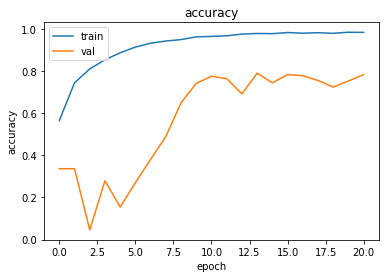

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

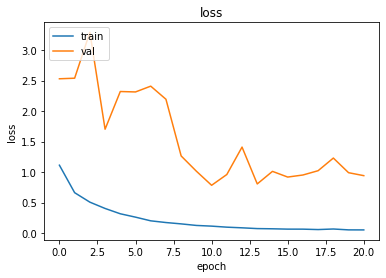

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluation

In [17]:
test_model = tf.keras.models.load_model('/content/HAM10000_ResNet50_Ver2_model.h5')

In [18]:
num_test_files = len(test_generator.filenames)

In [19]:
test_generator.reset()

In [20]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix


### Without Normalize

Confusion matrix, without normalization
[[26  2  5  0  0  0]
 [ 4 42  3  2  1  0]
 [ 6  3 87  0 14  0]
 [ 1  0  2  8  1  0]
 [ 3  2 11  1 95  0]
 [ 0  1  2  0  0 12]]


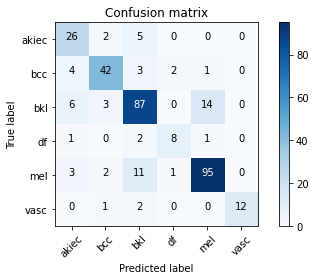

In [21]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.78787879 0.06060606 0.15151515 0.         0.         0.        ]
 [0.07692308 0.80769231 0.05769231 0.03846154 0.01923077 0.        ]
 [0.05454545 0.02727273 0.79090909 0.         0.12727273 0.        ]
 [0.08333333 0.         0.16666667 0.66666667 0.08333333 0.        ]
 [0.02678571 0.01785714 0.09821429 0.00892857 0.84821429 0.        ]
 [0.         0.06666667 0.13333333 0.         0.         0.8       ]]


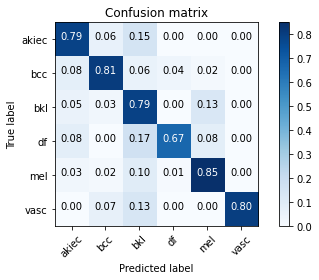

In [22]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [23]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[26  2  5  0  0  0]
 [ 4 42  3  2  1  0]
 [ 6  3 87  0 14  0]
 [ 1  0  2  8  1  0]
 [ 3  2 11  1 95  0]
 [ 0  1  2  0  0 12]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.65      0.79      0.71        33
         bcc       0.84      0.81      0.82        52
         bkl       0.79      0.79      0.79       110
          df       0.73      0.67      0.70        12
         mel       0.86      0.85      0.85       112
        vasc       1.00      0.80      0.89        15

    accuracy                           0.81       334
   macro avg       0.81      0.78      0.79       334
weighted avg       0.81      0.81      0.81       334



## PYCM

In [24]:
!pip3 install pycm==3.0 

     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 573kB 24.1MB/s 


In [25]:
from pycm import *

In [26]:
cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [27]:
cm.classes

[0, 1, 2, 3, 4, 5]

In [28]:
cm.table

{0: {0: 26, 1: 2, 2: 5, 3: 0, 4: 0, 5: 0},
 1: {0: 4, 1: 42, 2: 3, 3: 2, 4: 1, 5: 0},
 2: {0: 6, 1: 3, 2: 87, 3: 0, 4: 14, 5: 0},
 3: {0: 1, 1: 0, 2: 2, 3: 8, 4: 1, 5: 0},
 4: {0: 3, 1: 2, 2: 11, 3: 1, 4: 95, 5: 0},
 5: {0: 0, 1: 1, 2: 2, 3: 0, 4: 0, 5: 12}}

In [29]:
print(cm)

Predict  0        1        2        3        4        5        
Actual
0        26       2        5        0        0        0        

1        4        42       3        2        1        0        

2        6        3        87       0        14       0        

3        1        0        2        8        1        0        

4        3        2        11       1        95       0        

5        0        1        2        0        0        12       





Overall Statistics : 

95% CI                                                            (0.76617,0.85059)
ACC Macro                                                         0.93613
ARI                                                               0.56994
AUNP                                                              0.87053
AUNU                                                              0.8702
Bangdiwala B                                                      0.66896
Bennett S                                                  

### Grad-CAM

In [33]:
last_conv2d = 'conv5_block3_3_conv'

### AKIEC

In [34]:
akiec_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/akiec/ISIC_0026492.jpg' 

Model prediction:
	mel            	(4)	with probability 0.819
	bkl            	(2)	with probability 0.168
	akiec          	(0)	with probability 0.012
	bcc            	(1)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'mel'


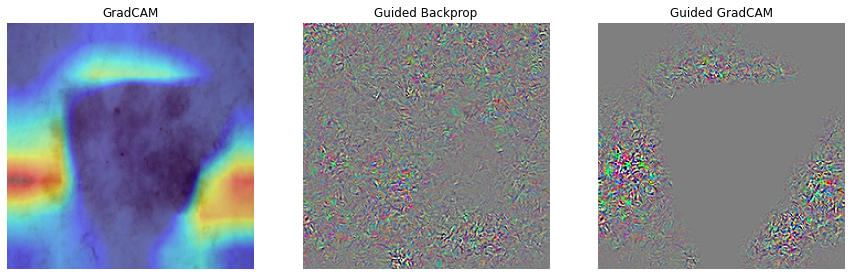

In [35]:
 gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

### BCC

In [36]:
bcc_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bcc/ISIC_0024332.jpg'

Model prediction:
	bkl            	(2)	with probability 0.899
	mel            	(4)	with probability 0.061
	df             	(3)	with probability 0.020
	akiec          	(0)	with probability 0.012
	bcc            	(1)	with probability 0.009
Explanation for 'bkl'


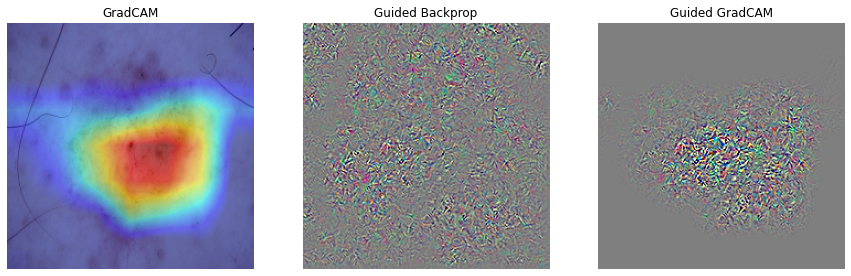

In [37]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bcc_img, layer_name=last_conv2d)

### BKL

In [38]:
bkl_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.999
	bkl            	(2)	with probability 0.001
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'mel'


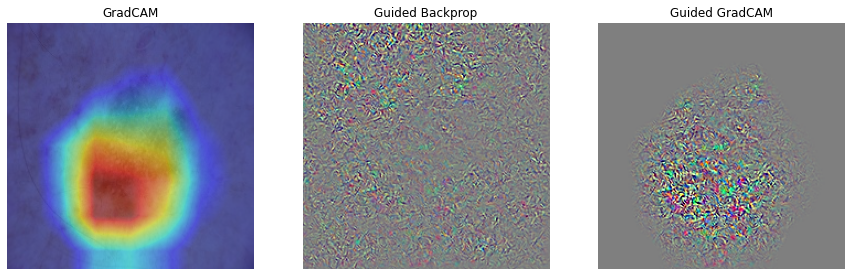

In [39]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bkl_img, layer_name=last_conv2d)

### DF

In [40]:
df_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_val/df/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.992
	df             	(3)	with probability 0.008
	bkl            	(2)	with probability 0.001
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'mel'


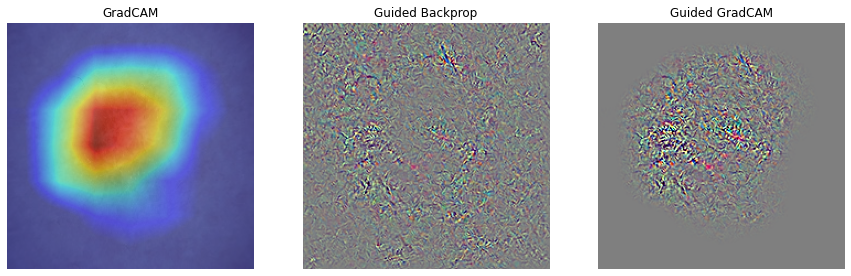

In [41]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, df_img, layer_name=last_conv2d)

### MEL

In [42]:
mel_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 1.000
	bkl            	(2)	with probability 0.000
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
	vasc           	(5)	with probability 0.000
Explanation for 'mel'


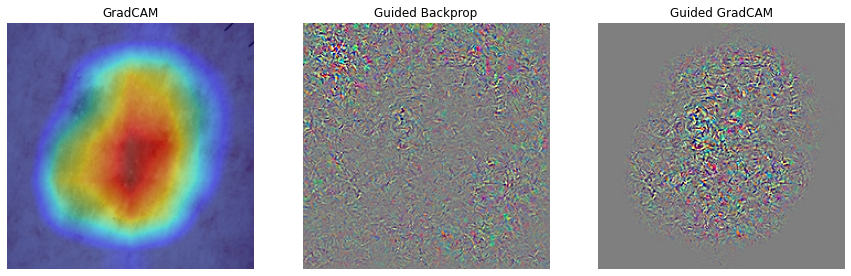

In [43]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, mel_img, layer_name=last_conv2d)

### VASC

In [44]:
vasc_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(5)	with probability 0.999
	mel            	(4)	with probability 0.001
	bcc            	(1)	with probability 0.000
	bkl            	(2)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'vasc'


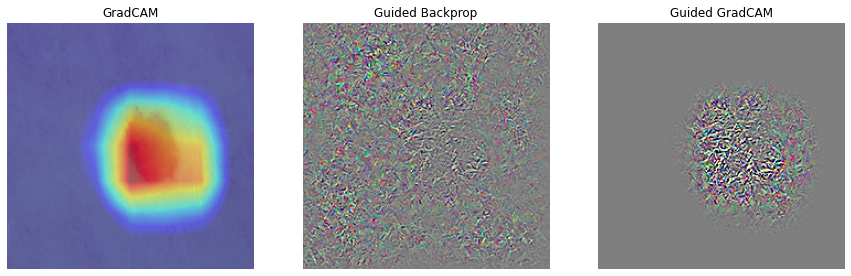

In [45]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, vasc_img, layer_name=last_conv2d)

# Download Model

In [46]:
from google.colab import files

In [47]:
files.download('/content/HAM10000_ResNet50_Ver2_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>